In [1]:
from maf import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--train', action='store_true', help='Train a flow.')
parser.add_argument('--evaluate', action='store_true', help='Evaluate a flow.')
parser.add_argument('--restore_file', type=str, help='Path to model to restore.')
parser.add_argument('--generate', action='store_true', help='Generate samples from a model.')
parser.add_argument('--data_dir', default='./data/', help='Location of datasets.')
parser.add_argument('--output_dir', default='./results/maf')
parser.add_argument('--results_file', default='results.txt', help='Filename where to store settings and test results.')
parser.add_argument('--no_cuda', action='store_true', help='Do not use cuda.')
# data
parser.add_argument('--dataset', default='toy', help='Which dataset to use.')
parser.add_argument('--flip_toy_var_order', action='store_true', help='Whether to flip the toy dataset variable order to (x2, x1).')
parser.add_argument('--seed', type=int, default=1, help='Random seed to use.')
# model
parser.add_argument('--model', default='maf', help='Which model to use: made, maf.')
# made parameters
parser.add_argument('--n_blocks', type=int, default=5, help='Number of blocks to stack in a model (MADE in MAF; Coupling+BN in RealNVP).')
parser.add_argument('--n_components', type=int, default=1, help='Number of Gaussian clusters for mixture of gaussians models.')
parser.add_argument('--hidden_size', type=int, default=100, help='Hidden layer size for MADE (and each MADE block in an MAF).')
parser.add_argument('--n_hidden', type=int, default=1, help='Number of hidden layers in each MADE.')
parser.add_argument('--activation_fn', type=str, default='relu', help='What activation function to use in the MADEs.')
parser.add_argument('--input_order', type=str, default='sequential', help='What input order to use (sequential | random).')
parser.add_argument('--conditional', default=False, action='store_true', help='Whether to use a conditional model.')
parser.add_argument('--no_batch_norm', action='store_true')
# training params
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--n_epochs', type=int, default=50)
parser.add_argument('--start_epoch', default=0, help='Starting epoch (for logging; to be overwritten when restoring file.')
parser.add_argument('--lr', type=float, default=1e-4, help='Learning rate.')
parser.add_argument('--log_interval', type=int, default=1000, help='How often to show loss statistics and save samples.')
parser.add_argument('--test_labels', default=False, action='store_true', help='Whether to use pre-specified Y labels for test generation.')
parser.add_argument('--use_weights', default=False, action='store_true', help='Whether to use weights.')
parser.add_argument('--concentration', type=float, default=0.0, help='NPL concentration parameter')
parser.add_argument('--T', type=int, default=10, help='number of prior samples')
parser.add_argument('--verbose', default=False, action='store_true', help='whether to print stuff')


_StoreTrueAction(option_strings=['--verbose'], dest='verbose', nargs=0, const=True, default=False, type=None, choices=None, help='whether to print stuff', metavar=None)

In [3]:
#args = parser.parse_args("--train --model=maf --dataset=GAUSSIANMIX --n_epochs=50 --batch_size=500 --use_weights --concentration=0.0 --T=10 --seed=4".split())
args = parser.parse_args("--train --model=maf --dataset=GAUSSIANMIX --n_epochs=100 --batch_size=100 --concentration=0.0 --T=10 --seed=4".split())




In [4]:
args.device = torch.device('cpu')
torch.manual_seed(args.seed)
if args.conditional: assert args.dataset in ['MNIST', 'CIFAR10', 'SYNTH', 'MOONS'], 'Conditional inputs only available for labeled datasets MNIST and CIFAR10.'
train_dataloader, test_dataloader = fetch_dataloaders(args.dataset, args.batch_size, args.device, args.flip_toy_var_order)
args.input_size = train_dataloader.dataset.input_size
args.input_dims = train_dataloader.dataset.input_dims
args.cond_label_size = train_dataloader.dataset.label_size if args.conditional else None

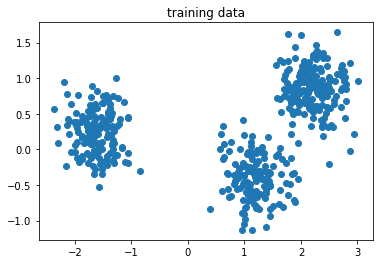

In [5]:

train_data = train_dataloader.dataset.X

train_data = train_data.detach().numpy()
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('training data')
plt.show()

# 1. Training a "standard" flow, with a Gaussian input

In [25]:
args = parser.parse_args("--train --model=maf --dataset=GAUSSIANMIX --n_epochs=100 --batch_size=100 --concentration=0.0 --T=0 --seed=4".split())
args.device = torch.device('cpu')
torch.manual_seed(args.seed)
if args.conditional: assert args.dataset in ['MNIST', 'CIFAR10', 'SYNTH', 'MOONS'], 'Conditional inputs only available for labeled datasets MNIST and CIFAR10.'
train_dataloader, test_dataloader = fetch_dataloaders(args.dataset, args.batch_size, args.device, args.flip_toy_var_order)
args.input_size = train_dataloader.dataset.input_size
args.input_dims = train_dataloader.dataset.input_dims
args.cond_label_size = train_dataloader.dataset.label_size if args.conditional else None


torch.manual_seed(args.seed)
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)

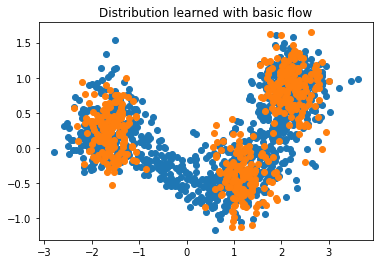

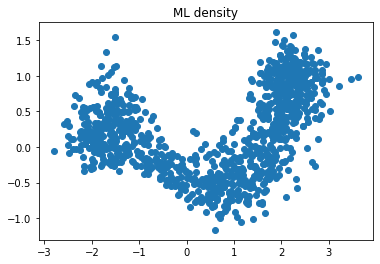

In [26]:
samples = []
for i in range(1000):
    u = model.base_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples.append(s.detach().numpy())
samples = np.array(samples).squeeze()
plt.scatter(samples[:, 0], samples[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow')
plt.show()

plt.scatter(samples[:, 0], samples[:, 1])
plt.title('ML density')
plt.show()

# 2. Training a standard flow using perturbations of the input, but then using the default base distribution

In [ ]:
torch.manual_seed(args.seed)
args.use_weights=True

In [ ]:
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)

In [ ]:
samples2 = []
for i in range(1000):
    u = model.base_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples2.append(s.detach().numpy())
samples2 = np.array(samples2).squeeze()
plt.scatter(samples2[:, 0], samples2[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow plus perturbed weights')
plt.show()

# Oh THAT isn't good...

## Oh wait... it's training to be good at sampling from the arbitrary distribution... but the mean and covariances aren't that

In [ ]:
meancovs = learn_dist(model, train_dataloader, args, 1000)

In [ ]:
means = np.array([meancovs[i][0].numpy() for i in range(len(meancovs))])
means.shape

In [ ]:
plt.scatter(means[:, 0], means[:, 1])
plt.show()

# 2a. Trained with perturbations, and then sampled from those perturbations... so basically, WLB

In [ ]:
samples2a = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples2a.append(s.detach().numpy())
samples2a = np.array(samples2a).squeeze()
plt.scatter(samples2a[:, 0], samples2a[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow plus perturbed weights, and corrected means')
plt.show()

# 3. Moving to actual NPL, with prior samples
### $\alpha=1, T=10$

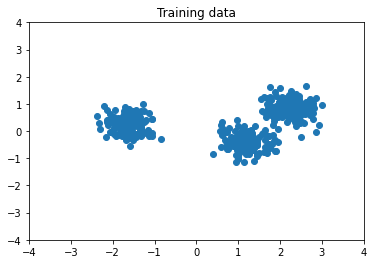

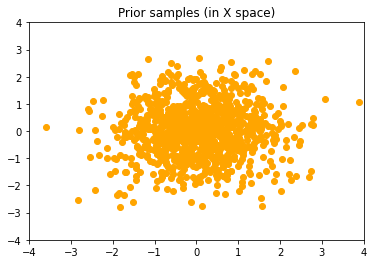

In [17]:
u_prior = D.Normal(torch.zeros(2), torch.ones(2))
prior_samples = u_prior.sample((1000, args.n_components)).detach().numpy().squeeze()
prior_samples.shape
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Training data')
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.show()

plt.scatter(prior_samples[:, 0], prior_samples[:, 1], color='orange')
plt.title('Prior samples (in X space)')
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.show()

In [ ]:

torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 1.0
args.T = 10
u_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, u_prior=u_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)

In [ ]:
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples3 = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples3.append(s.detach().numpy())
samples3 = np.array(samples3).squeeze()
plt.scatter(samples3[:, 0], samples3[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow plus perturbed weights, with alpha=1 and T=10')
plt.show()

## $\alpha=10, T=10$

In [ ]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 10.0
args.T = 10
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, u_prior=u_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples3a = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples3a.append(s.detach().numpy())
samples3a = np.array(samples3a).squeeze()
plt.scatter(samples3a[:, 0], samples3a[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow plus perturbed weights, with alpha=10 and T=10')
plt.show()

## $\alpha=100, T=10$



In [ ]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 100.0
args.T = 10
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, u_prior=u_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples3b = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples3b.append(s.detach().numpy())
samples3b = np.array(samples3b).squeeze()
plt.scatter(samples3b[:, 0], samples3b[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow plus perturbed weights, with alpha=100 and T=10')
plt.show()

## $\alpha=500, T=10$

In [ ]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 500.0
args.T = 10
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, u_prior=u_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples3c = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples3c.append(s.detach().numpy())
samples3c = np.array(samples3c).squeeze()
plt.scatter(samples3c[:, 0], samples3c[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution learned with basic flow plus perturbed weights, with alpha=500 and T=10')
plt.show()

# The "prior" we are pulling towards isn't a reasonable prior

## really, why would we expect it to be? We should get a better idea of whether it is "working" if we define our prior in output space...


# 4. NLP, with prior x_samples

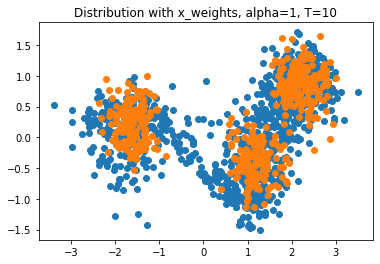

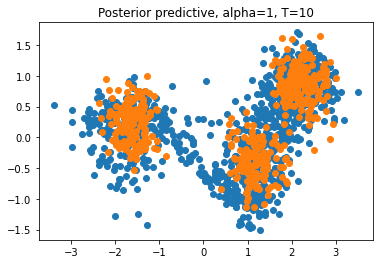

In [18]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 1.0
args.T = 10
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4a = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4a.append(s.detach().numpy())
samples4a = np.array(samples4a).squeeze()
plt.scatter(samples4a[:, 0], samples4a[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=1, T=10')
plt.show()

plt.scatter(samples4a[:, 0], samples4a[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Posterior predictive, alpha=1, T=10')
plt.show()

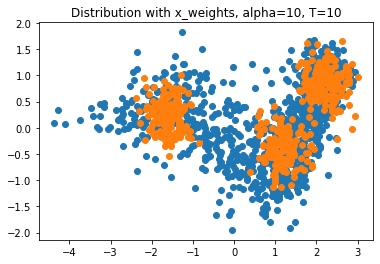

In [11]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 10.0
args.T = 10
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4b = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4b.append(s.detach().numpy())
samples4b = np.array(samples4b).squeeze()
plt.scatter(samples4b[:, 0], samples4b[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=10, T=10')
plt.show()

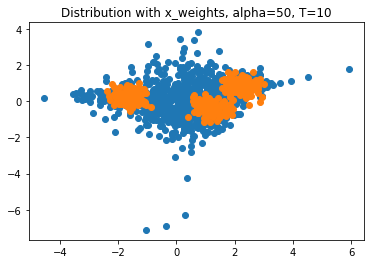

In [12]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 50.0
args.T = 10
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4c = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4c.append(s.detach().numpy())
samples4c = np.array(samples4c).squeeze()
plt.scatter(samples4c[:, 0], samples4c[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=50, T=10')
plt.show()

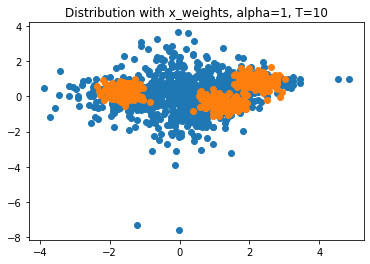

In [13]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 100.0
args.T = 10
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4d = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4d.append(s.detach().numpy())
samples4d = np.array(samples4d).squeeze()
plt.scatter(samples4d[:, 0], samples4d[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=1, T=10')
plt.show()

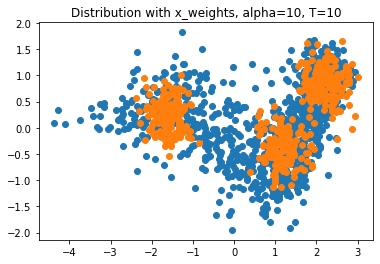

In [15]:
plt.scatter(samples4b[:, 0], samples4b[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=10, T=10')
plt.show()

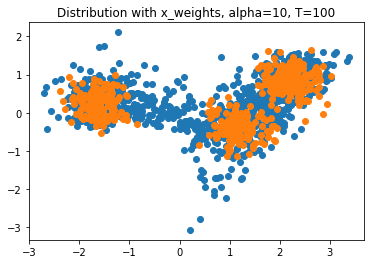

In [16]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 10.0
args.T = 100
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4e = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4e.append(s.detach().numpy())
samples4e = np.array(samples4e).squeeze()
plt.scatter(samples4e[:, 0], samples4e[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=10, T=100')
plt.show()

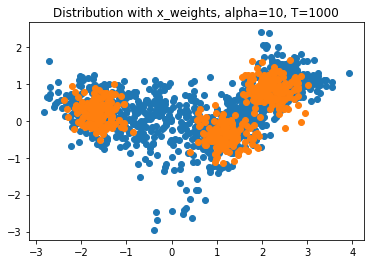

In [17]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 10.0
args.T = 1000
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4f = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4f.append(s.detach().numpy())
samples4f = np.array(samples4f).squeeze()
plt.scatter(samples4f[:, 0], samples4f[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=10, T=1000')
plt.show()

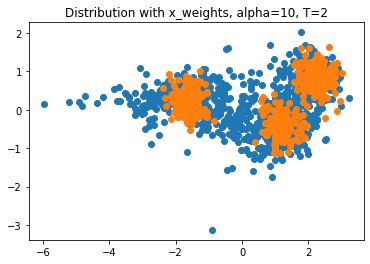

In [19]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 10.0
args.T = 2
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4g = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4g.append(s.detach().numpy())
samples4g = np.array(samples4g).squeeze()
plt.scatter(samples4g[:, 0], samples4g[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=10, T=2')
plt.show()

In [21]:
import seaborn as sns
import pandas as pd

samples4d_df = pd.DataFrame(samples4d)

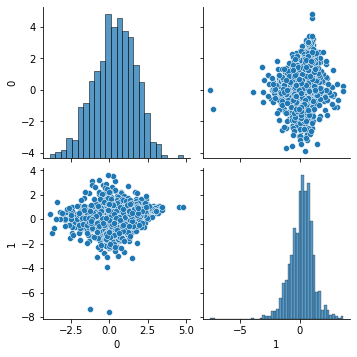

In [22]:
sns.pairplot(samples4d_df)
plt.show()

In [28]:
print('alpha=100, means={}, standard deviations = {}'.format(np.mean(samples4d, axis=0), np.std(samples4d, axis=0)))

alpha=100, means=[0.33603927 0.1366486 ], standard deviations = [1.3469274 1.0198615]


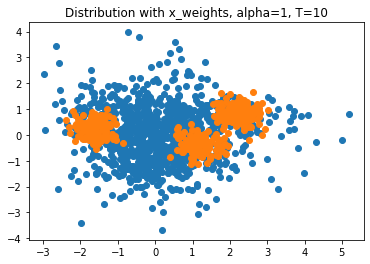

In [29]:
torch.manual_seed(args.seed)
args.use_weights = True
args.concentration = 1000.0
args.T = 10
x_prior = D.Normal(torch.zeros(2), torch.ones(2))
model = MAF(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.cond_label_size,
                    args.activation_fn, args.input_order, batch_norm=not args.no_batch_norm, x_prior=x_prior)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, args)
meancovs = learn_dist(model, train_dataloader, args, 1000)
samples4h = []
for i in range(1000):
    prior_dist = D.MultivariateNormal(meancovs[i][0], meancovs[i][1])
    u = prior_dist.sample((1, args.n_components)).squeeze(0)
    s, _ = model.inverse(u)
    samples4h.append(s.detach().numpy())
samples4h = np.array(samples4h).squeeze()
plt.scatter(samples4h[:, 0], samples4h[:, 1])
plt.scatter(train_data[:, 0], train_data[:, 1])
plt.title('Distribution with x_weights, alpha=1, T=10')
plt.show()

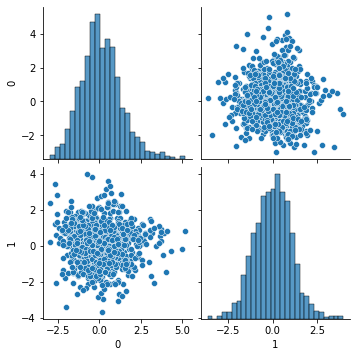

alpha=1000, means=[0.11330649 0.01783489], standard deviations = [1.2145901 1.0580223]


In [31]:
samples4h_df = pd.DataFrame(samples4h)
sns.pairplot(samples4h_df)
plt.show()
print('alpha=1000, means={}, standard deviations = {}'.format(np.mean(samples4h, axis=0), np.std(samples4h, axis=0)))


# FUCK YEAH.

# Next steps

* Come up with a good, real-world example... 
    * maybe look at transfer learning data?
    * Or, the Ian Osband paper (or follow-ups)?
* How does this compare with straight-up data augmentation? Is that a thing people do in transfer learning?
* Specifically, does this learn to output a combo of "things that look like the training data" and "things that look like the prior", or "things that look kind of like both?
* Think about what this would look like with the MLP formulation... is that even possible?
* Think about what the underlying Dirichlet process distribution really means... why DP not something else?
* Write up an email to Stephen Walker
* Implement density visualization